In [1]:
import numpy as np
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib
from qiskit.test.mock import FakeAlmaden
from qiskit.ignis.verification.tomography.data import marginal_counts

In [3]:
import pulse_compiler_helper_fns

In [4]:
backend = FakeAlmaden()
system = q.pulse.PulseChannelSpec.from_backend(backend)
back_config = backend.configuration().to_dict()
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])
backend_sim = qiskit.Aer.get_backend('pulse_simulator')

/Users/pranavgokhale/Developer/qiskit/qiskit-terra/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


In [40]:
hamiltonian = {}
hamiltonian['h_str'] = ['_SUM[i,0,1,wq{i}/2*(I{i}-Z{i})]', '_SUM[i,0,1,omegad{i}*X{i}||D{i}]',
                        'jq0q1*Sp0*Sm1', 'jq0q1*Sm0*Sp1', 'omegad1*X0||U0', 'omegad0*X1||U1']
hamiltonian['qub'] = {'0': 2, '1': 2}
hamiltonian['vars'] = {'wq0': 30.518812656662774, 'wq1': 31.238229295532093,
                       'omegad0': 0.1675, 'omegad1': 0.176,
                       'jq0q1': 0.0135}

back_config['hamiltonian'] = hamiltonian
back_config['noise'] = {}
back_config['dt'] = 1.0
back_config['ode_options'] = {}
back_config['qubit_list'] = [0,1]

In [53]:
# Measure X on target
x_schedules = []
for theta in np.linspace(0, 3*np.pi/4, 32, endpoint=False):
    schedule = pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system) 
    schedule |= cmd_def.get('u2', qubits=[1], P0=0, P1=np.pi) << schedule.duration
    schedule = schedule.filter(channels=[system.qubits[0].drive, system.qubits[1].drive, system.controls[0]])
    schedule |= measure << schedule.duration
    x_schedules.append(schedule)
    
# do same thing, but first flip 
for theta in np.linspace(0, 3*np.pi/4, 32, endpoint=False):
    schedule = cmd_def.get('x', qubits=[0])
    schedule |= pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system) << schedule.duration
    schedule |= cmd_def.get('u2', qubits=[1], P0=0, P1=np.pi) << schedule.duration
    schedule = schedule.filter(channels=[system.qubits[0].drive, system.qubits[1].drive, system.controls[0]])
    schedule |= measure << schedule.duration
    x_schedules.append(schedule)

In [42]:
shots = 1000

In [43]:
qobj = q.assemble(x_schedules, backend, 
                       meas_level=1, meas_return='avg', 
                       memory_slots=2,
                       shots=shots, sim_config = back_config)

In [44]:
evals, estates = backend_sim.get_dressed_energies(qobj)
evals/2/np.pi

array([0.        , 4.85717964, 4.97175886, 9.82893851])

In [54]:
# Measure Y on target
y_schedules = []
for theta in np.linspace(0, 3*np.pi/4, 32, endpoint=False):
    schedule = pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system)
    schedule |= cmd_def.get('u1', qubits=[1], P0=-np.pi/2) << schedule.duration
    schedule |= cmd_def.get('u2', qubits=[1], P0=0, P1=np.pi) << schedule.duration
    schedule = schedule.filter(channels=[system.qubits[0].drive, system.qubits[1].drive, system.controls[0]])
    schedule |= measure << schedule.duration
    y_schedules.append(schedule)
    
# do same thing, but first flip 
for theta in np.linspace(0, 3*np.pi/4, 32, endpoint=False):
    schedule = cmd_def.get('x', qubits=[0])
    schedule |= pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system) << schedule.duration
    schedule |= cmd_def.get('u1', qubits=[1], P0=-np.pi/2) << schedule.duration
    schedule |= cmd_def.get('u2', qubits=[1], P0=0, P1=np.pi) << schedule.duration
    schedule = schedule.filter(channels=[system.qubits[0].drive, system.qubits[1].drive, system.controls[0]])
    schedule |= measure << schedule.duration
    y_schedules.append(schedule)

In [55]:
# Measure Z on target
z_schedules = []
for theta in np.linspace(0, 3*np.pi/4, 32, endpoint=False):
    schedule = pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system)
    schedule = schedule.filter(channels=[system.qubits[0].drive, system.qubits[1].drive, system.controls[0]])
    schedule |= measure << schedule.duration
    z_schedules.append(schedule)
    
# do same thing, but first flip 
for theta in np.linspace(0, 3*np.pi/4, 32, endpoint=False):
    schedule = cmd_def.get('x', qubits=[0])
    schedule |= pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system) << schedule.duration
    schedule = schedule.filter(channels=[system.qubits[0].drive, system.qubits[1].drive, system.controls[0]])
    schedule |= measure << schedule.duration
    z_schedules.append(schedule)

In [56]:
shots = 10000

qobj = q.assemble(x_schedules, backend, 
                     qubit_lo_freq = [evals[1]/2/np.pi, evals[2]/2/np.pi],
                     shots=shots, sim_config = back_config)
x_result = backend_sim.run(qobj).result()

qobj = q.assemble(y_schedules, backend, 
                     qubit_lo_freq = [evals[1]/2/np.pi, evals[2]/2/np.pi],
                     shots=shots, sim_config = back_config)
y_result = backend_sim.run(qobj).result()

qobj = q.assemble(z_schedules, backend, 
                     qubit_lo_freq = [evals[1]/2/np.pi, evals[2]/2/np.pi],
                     shots=shots, sim_config = back_config)
z_result = backend_sim.run(qobj).result()

In [48]:
from qiskit.ignis.verification.tomography.data import marginal_counts

In [67]:
x_vals_control_off = []
for i in range(32):
    x_counts = marginal_counts(x_result.get_counts(i), meas_qubits=[1])
    x_vals_control_off.append((x_counts.get('0', 0) / shots - 0.5) * 2)

x_vals_control_on = []
for i in range(32, 64):
    x_counts = marginal_counts(x_result.get_counts(i), meas_qubits=[1])
    x_vals_control_on.append((x_counts.get('0', 0) / shots - 0.5) * 2)

print(x_vals_control_off)
print(x_vals_control_on)

[-0.015000000000000013, -0.031399999999999983, -0.06740000000000002, -0.11719999999999997, -0.1612, -0.18079999999999996, -0.1996, -0.2148, -0.2218, -0.24, -0.21899999999999997, -0.21540000000000004, -0.18899999999999995, -0.17679999999999996, -0.1452, -0.10260000000000002, -0.0766, -0.026000000000000023, 0.0052000000000000934, 0.05400000000000005, 0.08620000000000005, 0.10899999999999999, 0.1664000000000001, 0.1883999999999999, 0.1814, 0.1923999999999999, 0.2023999999999999, 0.1814, 0.18159999999999998, 0.1803999999999999, 0.1541999999999999, 0.1279999999999999]
[0.016999999999999904, 0.0411999999999999, 0.07640000000000002, 0.0988, 0.10499999999999998, 0.09440000000000004, 0.07820000000000005, 0.028799999999999937, -0.023399999999999976, -0.09399999999999997, -0.15859999999999996, -0.21960000000000002, -0.2602, -0.2986, -0.30800000000000005, -0.28, -0.23260000000000003, -0.20240000000000002, -0.15039999999999998, -0.08299999999999996, -0.006199999999999983, 0.07539999999999991, 0.124

In [68]:
y_vals_control_off = []
for i in range(32):
    y_counts = marginal_counts(y_result.get_counts(i), meas_qubits=[1])
    y_vals_control_off.append((y_counts.get('0', 0) / shots - 0.5) * 2)

y_vals_control_on = []
for i in range(32, 64):
    y_counts = marginal_counts(y_result.get_counts(i), meas_qubits=[1])
    y_vals_control_on.append((y_counts.get('0', 0) / shots - 0.5) * 2)

print(y_vals_control_off)
print(y_vals_control_on)

[0.0034000000000000696, 0.15280000000000005, 0.3124, 0.43599999999999994, 0.5780000000000001, 0.6724000000000001, 0.7674000000000001, 0.8435999999999999, 0.9014, 0.9410000000000001, 0.9685999999999999, 0.9743999999999999, 0.9614, 0.9281999999999999, 0.8806, 0.8053999999999999, 0.7030000000000001, 0.6184000000000001, 0.4930000000000001, 0.36739999999999995, 0.25340000000000007, 0.11080000000000001, -0.0252, -0.1562, -0.2794, -0.3798, -0.49319999999999997, -0.5946, -0.6841999999999999, -0.7602, -0.8424, -0.894]
[-0.014000000000000012, -0.14300000000000002, -0.29259999999999997, -0.43479999999999996, -0.5591999999999999, -0.704, -0.7948, -0.8712, -0.9292, -0.9654, -0.9832, -0.974, -0.95, -0.902, -0.8386, -0.7736000000000001, -0.6898, -0.5864, -0.493, -0.38439999999999996, -0.24960000000000004, -0.14600000000000002, -0.017000000000000015, 0.10519999999999996, 0.24540000000000006, 0.3575999999999999, 0.4910000000000001, 0.5840000000000001, 0.688, 0.7834000000000001, 0.8488, 0.899]


In [69]:
z_vals_control_off = []
for i in range(32):
    z_counts = marginal_counts(z_result.get_counts(i), meas_qubits=[1])
    z_vals_control_off.append((z_counts.get('0', 0) / shots - 0.5) * 2)

z_vals_control_on = []
for i in range(32, 64):
    z_counts = marginal_counts(z_result.get_counts(i), meas_qubits=[1])
    z_vals_control_on.append((z_counts.get('0', 0) / shots - 0.5) * 2)

print(z_vals_control_off)
print(z_vals_control_on)

[1.0, 0.9885999999999999, 0.9558, 0.889, 0.8162, 0.7290000000000001, 0.6137999999999999, 0.48360000000000003, 0.3458000000000001, 0.24059999999999993, 0.08739999999999992, -0.025399999999999978, -0.1986, -0.31120000000000003, -0.46519999999999995, -0.5922000000000001, -0.6978, -0.7986, -0.8688, -0.926, -0.966, -0.9832, -0.9896, -0.9776, -0.9422, -0.9014, -0.8473999999999999, -0.7846, -0.712, -0.6226, -0.5306, -0.43920000000000003]
[1.0, 0.986, 0.9536, 0.8937999999999999, 0.8184, 0.7094, 0.6155999999999999, 0.48540000000000005, 0.37159999999999993, 0.22859999999999991, 0.09600000000000009, -0.0514, -0.19320000000000004, -0.3328, -0.45220000000000005, -0.5740000000000001, -0.7028, -0.7908, -0.8696, -0.9256, -0.9686, -0.9886, -0.9896, -0.9776, -0.9494, -0.9122, -0.8444, -0.7807999999999999, -0.6988, -0.6278, -0.5298, -0.44699999999999995]


In [74]:
x_vals_control_off = [-0.015000000000000013, -0.031399999999999983, -0.06740000000000002, -0.11719999999999997, -0.1612, -0.18079999999999996, -0.1996, -0.2148, -0.2218, -0.24, -0.21899999999999997, -0.21540000000000004, -0.18899999999999995, -0.17679999999999996, -0.1452, -0.10260000000000002, -0.0766, -0.026000000000000023, 0.0052000000000000934, 0.05400000000000005, 0.08620000000000005, 0.10899999999999999, 0.1664000000000001, 0.1883999999999999, 0.1814, 0.1923999999999999, 0.2023999999999999, 0.1814, 0.18159999999999998, 0.1803999999999999, 0.1541999999999999, 0.1279999999999999]
x_vals_control_on = [0.016999999999999904, 0.0411999999999999, 0.07640000000000002, 0.0988, 0.10499999999999998, 0.09440000000000004, 0.07820000000000005, 0.028799999999999937, -0.023399999999999976, -0.09399999999999997, -0.15859999999999996, -0.21960000000000002, -0.2602, -0.2986, -0.30800000000000005, -0.28, -0.23260000000000003, -0.20240000000000002, -0.15039999999999998, -0.08299999999999996, -0.006199999999999983, 0.07539999999999991, 0.12460000000000004, 0.1674, 0.1903999999999999, 0.2048000000000001, 0.1806000000000001, 0.1524000000000001, 0.139, 0.08139999999999992, 0.0351999999999999, 0.012399999999999967]
y_vals_control_off = [0.0034000000000000696, 0.15280000000000005, 0.3124, 0.43599999999999994, 0.5780000000000001, 0.6724000000000001, 0.7674000000000001, 0.8435999999999999, 0.9014, 0.9410000000000001, 0.9685999999999999, 0.9743999999999999, 0.9614, 0.9281999999999999, 0.8806, 0.8053999999999999, 0.7030000000000001, 0.6184000000000001, 0.4930000000000001, 0.36739999999999995, 0.25340000000000007, 0.11080000000000001, -0.0252, -0.1562, -0.2794, -0.3798, -0.49319999999999997, -0.5946, -0.6841999999999999, -0.7602, -0.8424, -0.894]
y_vals_control_on = [-0.014000000000000012, -0.14300000000000002, -0.29259999999999997, -0.43479999999999996, -0.5591999999999999, -0.704, -0.7948, -0.8712, -0.9292, -0.9654, -0.9832, -0.974, -0.95, -0.902, -0.8386, -0.7736000000000001, -0.6898, -0.5864, -0.493, -0.38439999999999996, -0.24960000000000004, -0.14600000000000002, -0.017000000000000015, 0.10519999999999996, 0.24540000000000006, 0.3575999999999999, 0.4910000000000001, 0.5840000000000001, 0.688, 0.7834000000000001, 0.8488, 0.899]
z_vals_control_off = [1.0, 0.9885999999999999, 0.9558, 0.889, 0.8162, 0.7290000000000001, 0.6137999999999999, 0.48360000000000003, 0.3458000000000001, 0.24059999999999993, 0.08739999999999992, -0.025399999999999978, -0.1986, -0.31120000000000003, -0.46519999999999995, -0.5922000000000001, -0.6978, -0.7986, -0.8688, -0.926, -0.966, -0.9832, -0.9896, -0.9776, -0.9422, -0.9014, -0.8473999999999999, -0.7846, -0.712, -0.6226, -0.5306, -0.43920000000000003]
z_vals_control_on = [1.0, 0.986, 0.9536, 0.8937999999999999, 0.8184, 0.7094, 0.6155999999999999, 0.48540000000000005, 0.37159999999999993, 0.22859999999999991, 0.09600000000000009, -0.0514, -0.19320000000000004, -0.3328, -0.45220000000000005, -0.5740000000000001, -0.7028, -0.7908, -0.8696, -0.9256, -0.9686, -0.9886, -0.9896, -0.9776, -0.9494, -0.9122, -0.8444, -0.7807999999999999, -0.6988, -0.6278, -0.5298, -0.44699999999999995]

[0, 32, -1, 1]

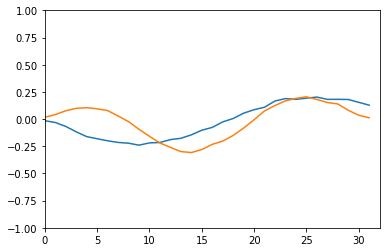

In [75]:
plt.plot(x_vals_control_off)
plt.plot(x_vals_control_on)
plt.axis([0, 32, -1, 1])

[0, 32, -1, 1]

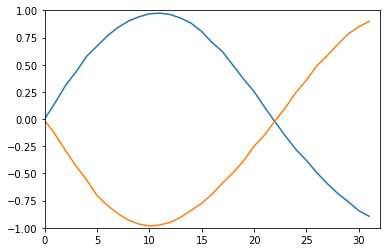

In [76]:
plt.plot(y_vals_control_off)
plt.plot(y_vals_control_on)
plt.axis([0, 32, -1, 1])

[0, 32, -1, 1]

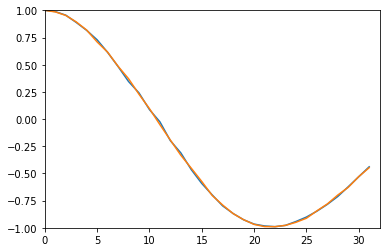

In [78]:
plt.plot(z_vals_control_off)
plt.plot(z_vals_control_on)
plt.axis([0, 32, -1, 1])